# **PROYECTO CODERHOUSE**

### ***Contexto analitico:***

*Somos cientificos de datos para importante empresa de finanzas en donde asesoran a otras empresas acerca del mercado de valores. Para ello, la empresa sigue constante los portales de noticias para estar al tanto de posibles oportunidades o eventos que afecten al mercado.*

### ***Problematica actual:***

*Debido al creciente aumento de las noticias falsas, es dificil discernir que decision tomar en base a las noticias. Entonces, la direccion de estrategias se reunio con el equipo de data science para aborar la problematica de la siguiente forma:*

1. *Obtener respuestas utilizando NPL que orienten a la empresa en esta tematica*
2. *Realizar un modelo predictivo que identifique las noticias verdaderas*



> *Fuente:* [texto del enlace](https://www.kaggle.com/datasets/razanaqvi14/real-and-fake-news?resource=download)





## **ANALISIS EXPLORATORIO DE LOS DATOS**

In [1]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
#Importamos CSV con los que trabajaremos
df_true = pd.read_csv('True.csv')
df_false = pd.read_csv('Fake.csv')

In [3]:
#Visualizamos los datos de los DF importados
print(f"Filas y columnas en df_true:{df_true.shape}")
print(f"Filas y columnas en df_false:{df_false.shape}")

Filas y columnas en df_true:(21417, 4)
Filas y columnas en df_false:(23481, 4)


In [4]:
#Primer DF TRUE
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
#Segundo DF FALSE
df_false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
#Comprobamos nulos
df_true.isnull().sum()

,0
title,0
text,0
subject,0
date,0


In [7]:
#Comprobamos nulos
df_false.isnull().sum()

,0
title,0
text,0
subject,0
date,0


Ambos DF sin datos nulos

## **NLP**

Utilizamos herramientas de NPL para obtener un top 10 de palabras mas utilizadas en los titulos de las noticias, tanto las verdaderas como las falsas. Luego, creamos una nube de palabras para obtener una comparativa visual de las mismas.

In [8]:
# Etiquetamos los datos
df_true["label"] = 1  # Noticias verdaderas
df_false["label"] = 0  # Noticias falsas

# Unificamos los dataframes
df = pd.concat([df_true, df_false]).sample(frac=1).reset_index(drop=True)

# Nos quedamos con las columnas que nos interesan
df = df[['title', 'label']]

In [9]:
# Lista de palabras vacías (stopwords)
stop_words = set(stopwords.words('english'))

# Función para limpiar cada título
def clean_text(text):
    # Pasamos a minúsculas
    text = text.lower()
    # Tokenizamos
    tokens = word_tokenize(text)
    # Filtramos: eliminamos puntuación, stopwords y no alfabéticas
    words = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Unir de nuevo en un string
    return " ".join(words)

# Aplicamos limpieza a los títulos
df["title_clean"] = df["title"].apply(clean_text)

In [10]:
# Lista de palabras vacías (stopwords)
stop_words = set(stopwords.words('english'))

# Función para limpiar cada título y devolver una lista de tokens
def clean_and_tokenize(text):
    # Pasamos a minúsculas
    text = text.lower()
    # Tokenizamos
    tokens = word_tokenize(text)
    # Filtramos: eliminamos puntuación, palabras vacías y no alfabéticas
    words = [word for word in tokens if word.isalpha() and word not in stop_words]
    return words

# Aplicamos limpieza y tokenización a los títulos
df["tokens"] = df["title"].apply(clean_and_tokenize)

# Separamos tokens por tipo de noticia usando las etiquetas numéricas
# Concatenamos todas las listas de tokens para cada category
tokens_fake = [token for sublist in df[df['label'] == 0]['tokens'] for token in sublist]
tokens_true = [token for sublist in df[df['label'] == 1]['tokens'] for token in sublist]

# Contamos palabras más frecuentes
top_fake = Counter(tokens_fake).most_common(10)
top_true = Counter(tokens_true).most_common(10)

print("🟥 Palabras más comunes en noticias falsas:")
print(top_fake)

print("\n🟩 Palabras más comunes en noticias verdaderas:")
print(top_true)

🟥 Palabras más comunes en noticias falsas:
[('trump', 8694), ('video', 8373), ('obama', 2476), ('hillary', 2189), ('watch', 1901), ('clinton', 1099), ('president', 1089), ('new', 895), ('breaking', 880), ('news', 858)]

🟩 Palabras más comunes en noticias verdaderas:
[('trump', 5400), ('says', 2981), ('house', 1442), ('north', 925), ('russia', 912), ('korea', 881), ('new', 862), ('white', 807), ('china', 766), ('senate', 759)]


<ipython-input-11-23c45d861bdb>:25: UserWarning: Glyph 128997 (\N{LARGE RED SQUARE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-11-23c45d861bdb>:25: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128997 (\N{LARGE RED SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


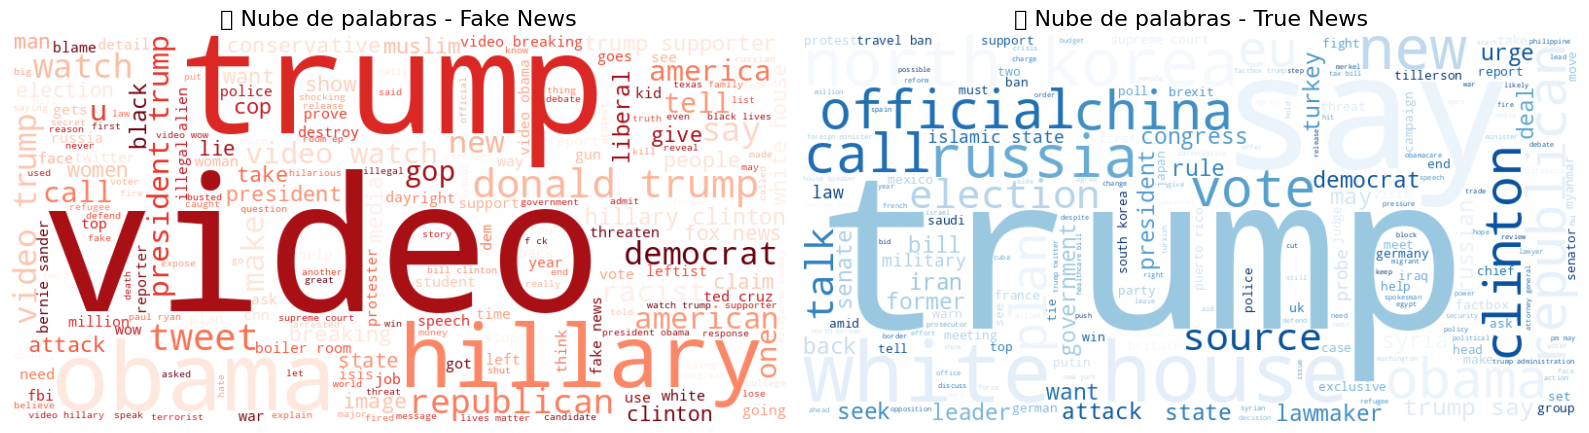

In [11]:
# Unir todos los tokens en una sola cadena de texto
# Cambiamos 'fake' por 0 y 'true' por 1 para que coincida con las etiquetas numéricas
fake_text = ' '.join(df[df['label'] == 0]['tokens'].sum())
true_text = ' '.join(df[df['label'] == 1]['tokens'].sum())

# Crear objetos WordCloud
wc_fake = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(fake_text)
wc_true = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(true_text)

# Mostrar ambas nubes
plt.figure(figsize=(16, 8))

#Etiquetamos
plt.subplot(1, 2, 1)
plt.imshow(wc_fake, interpolation='bilinear')
plt.axis('off')
plt.title('🟥 Nube de palabras - Fake News', fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(wc_true, interpolation='bilinear')
plt.axis('off')
plt.title('🟦 Nube de palabras - True News', fontsize=16)

#Mostramos
plt.tight_layout()
plt.show()

### **CONCLUSIÓN - NLP**

Como se observa en la imagen, en comparación con las noticias reales, las noticias falsas tienden a utilizar palabras más comunes y repetitivas, destacándose especialmente los nombres de mandatarios políticos. Un término que resalta con frecuencia es **"video"**, lo cual podría estar relacionado con una estrategia para atraer más interacciones, apelando a la supuesta existencia de material audiovisual relevante.

En contraste, las noticias reales, aunque también mencionan figuras políticas como el presidente **Trump**, aunque lo hacen con menor frecuencia y en contextos más formales, como corresponde a un presidente electo. Además, el vocabulario en este tipo de noticias se orienta más a hechos concretos, utilizando verbos como "say", "vote", "call" o "talk".

**En conclusión**, las noticias falsas suelen centrarse en figuras políticas y en la mención de videos con fines sensacionalistas, mientras que las noticias reales utilizan un lenguaje más objetivo y basado en hechos verificables.


## **MPL (MULTILAYER PERCEPTON)**

En el siguiente paso el equipo de Data Science de la empresa desarrollara y entrenara una red neuronal sencilla a bien que pueda predecir la veracidad de los titulos de noticias.



In [12]:
# Creamos el tokenizer con un vocabulario de hasta 5000 palabras y un token para palabras desconocidas
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")

# Ajustamos el tokenizer al texto de los títulos
tokenizer.fit_on_texts(df['title'])

# Convertimos los títulos en secuencias numéricas
sequences = tokenizer.texts_to_sequences(df['title'])

# Rellenamos o recortamos las secuencias a una longitud fija de 30
padded = pad_sequences(sequences, maxlen=30, padding='post', truncating='post')


In [13]:
# Codificamos las etiquetas ('label') en valores numéricos (por ejemplo, FAKE = 0, REAL = 1)
labels = LabelEncoder().fit_transform(df['label'])

In [14]:
#Creamos el modelo de red neuronal
model = Sequential([
    Embedding(input_dim=5000, output_dim=16, input_length=30),
    GlobalAveragePooling1D(),
    Dense(24, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),  # ← Capa para prevenir sobreajuste
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
# Dividimos los datos en conjunto temporal (90%) y prueba (10%)
X_temp, X_test, y_temp, y_test = train_test_split(padded, labels, test_size=0.1, random_state=42)

# Dividimos el conjunto temporal en entrenamiento (80%) y validación (20%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Detenemos el entrenamiento si la pérdida de validación no mejora después de 2 épocas
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Compilamos el modelo con función de pérdida binaria y optimizador Adam
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamos el modelo con validación y early stopping
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7994 - loss: 0.4862 - val_accuracy: 0.9543 - val_loss: 0.1711
Epoch 2/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9538 - loss: 0.1741 - val_accuracy: 0.9621 - val_loss: 0.1318
Epoch 3/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9670 - loss: 0.1326 - val_accuracy: 0.9667 - val_loss: 0.1148
Epoch 4/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9730 - loss: 0.1095 - val_accuracy: 0.9678 - val_loss: 0.1073
Epoch 5/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9774 - loss: 0.0941 - val_accuracy: 0.9665 - val_loss: 0.1048
Epoch 6/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9800 - loss: 0.0838 - val_accuracy: 0.9691 - val_loss: 0.1025
Epoch 7/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9812 - loss: 0.0764 - val_accuracy: 0.9717 - val_loss: 0.0962
Epoch 8/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9822 - loss: 0.0702 - 

In [16]:
# Ahora podemos evaluar en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Pérdida en conjunto de prueba: {loss:.4f}, Precisión en conjunto de prueba: {accuracy:.4f}')

# También podemos hacer predicciones en el conjunto de prueba
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Fake', 'True']))

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9668 - loss: 0.1105
Pérdida en conjunto de prueba: 0.0976, Precisión en conjunto de prueba: 0.9699
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[2231   74]
 [  61 2124]]
              precision    recall  f1-score   support

        Fake       0.97      0.97      0.97      2305
        True       0.97      0.97      0.97      2185

    accuracy                           0.97      4490
   macro avg       0.97      0.97      0.97      4490
weighted avg       0.97      0.97      0.97      4490



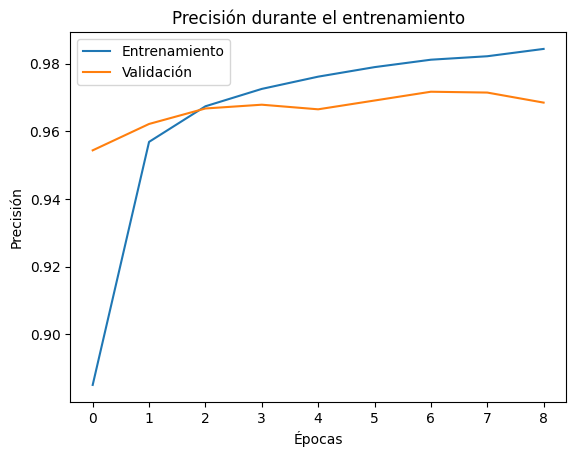

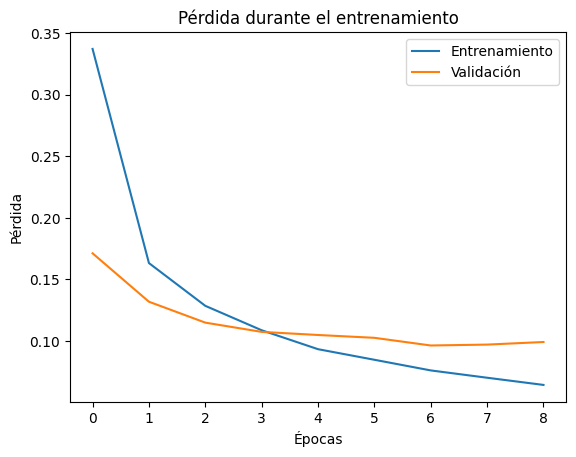

In [17]:
# Comprobamos si no hay sobre ajuste en el modelo graficando.

# Graficamos la precisión en entrenamiento y validación por época
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficamos la pérdida (loss) en entrenamiento y validación por época
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

En el gráfico podemos observar que tanto la precisión como la pérdida durante el entrenamiento y la validación son similares; es decir, que el modelo no presenta sobreajuste.

In [18]:
#Ejemplo con una noticia verdadera
noticia_verdadera = ["President resigns after scandal"]

# Preprocesamos como antes
seq = tokenizer.texts_to_sequences(noticia_verdadera)
padded_seq = pad_sequences(seq, maxlen=30, padding='post')

# Predecimos
pred = model.predict(padded_seq)
print("Probabilidad de que sea verdadera:", float(pred[0][0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Probabilidad de que sea verdadera: 0.9780201315879822


In [19]:
# Ejemplo de una noticia falsa
noticia_fake = ["NASA confirms the sun will go completely dark for 6 days in November"]

# Conviertimos el texto a una secuencia numérica
seq_fake = tokenizer.texts_to_sequences(noticia_fake)
padded_fake = pad_sequences(seq_fake, maxlen=30, padding='post')

# Realizamos la predicción con el modelo
prediccion = model.predict(padded_fake)[0][0]

# Imprimimos la probabilidad de que sea una noticia real
print(f"Probability of being REAL: {prediccion:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Probability of being REAL: 0.0148


# ***CONCLUSION GENERAL***





## Detección de Noticias Falsas con NLP y Deep Learning

Este proyecto tuvo como objetivo principal desarrollar un modelo capaz de **distinguir entre noticias reales y falsas** utilizando técnicas de **Procesamiento de Lenguaje Natural (NLP)** y **Deep Learning**. Se abordó el problema desde una perspectiva completa, cubriendo desde el análisis exploratorio hasta la evaluación de un modelo predictivo.

---

### Fase 1: NLP (Procesamiento de Lenguaje Natural)

En esta etapa, se aplicaron herramientas de la librería **NLTK** para procesar los textos, con los siguientes pasos:

- Limpieza de los títulos de noticias.
- Tokenización y eliminación de stopwords.
- Visualización de las palabras más frecuentes mediante **gráficos y nubes de palabras**, diferenciando entre noticias reales y falsas.

Esta etapa permitió identificar patrones léxicos distintos entre ambos grupos y ofreció una base sólida para el entrenamiento posterior del modelo.

---

### Fase 2: Deep Learning

Se construyó un modelo de red neuronal secuencial con **Keras** que incluye:

- Una capa de embedding para representar las palabras como vectores.
- Capa de pooling para reducir dimensionalidad.
- Capas densas con activación `ReLU` y `sigmoid`.
- Técnicas para evitar el sobreajuste como **Dropout** y **EarlyStopping**.

El modelo alcanzó una **alta precisión (superior al 97%)** sobre los datos de validación, demostrando su eficacia para predecir la veracidad de una noticia basada únicamente en su título.

---

### Resultados y Validación

- El modelo fue capaz de clasificar correctamente títulos reales y falsos.
- Se evaluó con títulos inventados y reales, obteniendo predicciones coherentes.
- Se controló el sobreajuste durante el entrenamiento para mejorar la capacidad de generalización.

---

### Conclusión Final

El proyecto demuestra que es posible aplicar técnicas de **NLP combinadas con Deep Learning** para construir un sistema eficaz de **detección de noticias falsas**, incluso usando únicamente los títulos. Este enfoque puede ampliarse fácilmente al análisis de textos completos, incorporación de metadatos y despliegue en aplicaciones reales para combatir la desinformación en medios digitales.

